## Lab 3: Anomaly Detection 1

In this lab, you will be working with detecting anomalies in data. You will use basic Python libraries and the PyOD (https://pyod.readthedocs.io/en/latest/) library for detecting anomalies. Save your implementations with the name 'lab2_yourname.ipynb' and submit by the due date.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option("display.max_columns",100)
from pyod.utils.example import visualize
from pyod.utils.data import evaluate_print

## Data overview

This dataset contains information on variants of the French wine. The dataset contains information on physicochemical variables that were recorded on different wine samples.

There 6497 datapoints and twelve variables, namely: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol level and quality.


In [27]:
wine_data= pd.read_excel('wine_data.xls')
wine_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [28]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


Lets engineer a new feature 'score' that assigns values to the wine samples based on the quality.

In [29]:
#New feature
wine_data['score'] = [1 if x >= 5 else 0 for x in wine_data['quality']]

In [30]:
#For simplicity, we will now filter the dataset to a few features
wine_filtered=wine_data[['fixed acidity','volatile acidity', 'score']]

<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### Data visualization as a tool for anomaly detection

</div>

The simplest way to detect any anomalies or outliers in your dataset is to plot the data to identify any outlier patterns. 
In the example below, we implement a boxplot on feature: fixed acidity and a histogram on feature: volatile acidity to check for outliers.

{'whiskers': [<matplotlib.lines.Line2D at 0x192a26acc10>,
 'caps': [<matplotlib.lines.Line2D at 0x192a26ae150>,
 'boxes': [<matplotlib.lines.Line2D at 0x192df8b3050>],
 'medians': [<matplotlib.lines.Line2D at 0x192a26af150>],
 'fliers': [<matplotlib.lines.Line2D at 0x192a26afa50>],
 'means': []}

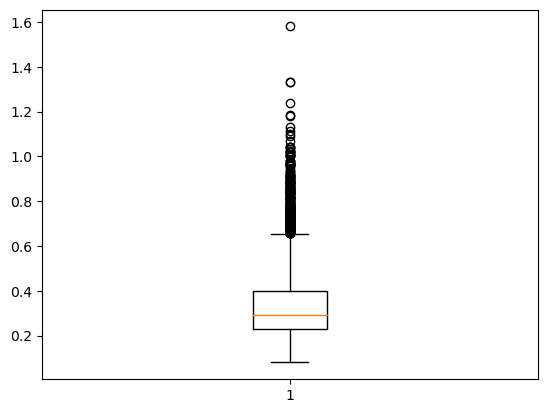

In [31]:
plt.boxplot(wine_filtered['volatile acidity'])

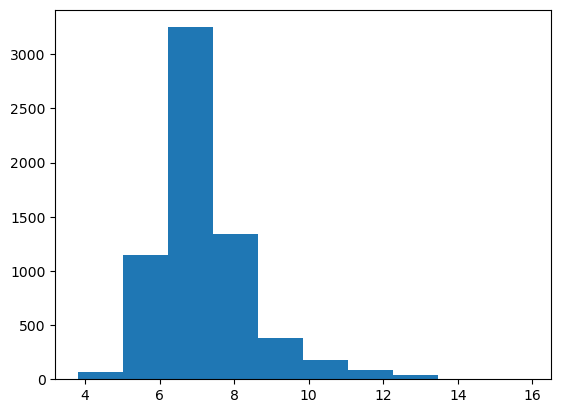

In [32]:
plt.hist(wine_filtered['fixed acidity'])
hist, bin_edges=np.histogram(wine_filtered['fixed acidity'].to_numpy(), density=False, bins=2)

<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### PyOD for anomaly detection

</div>


## Data Preparation


In [33]:
#we will use the 'score' as the labels and assign 'fixed acidity' and 'volatile acidity' as the features
labels=wine_filtered['score']
data=wine_filtered[['fixed acidity','volatile acidity']]

In [34]:
#we will use the standardizer from the PyOD library
from pyod.utils.utility import standardizer
data_std=standardizer(data)

In [35]:
#split percentage
split = int(0.7 * len(data))

train_data = data_std[:split]
test_data= data_std[split:]
train_labels= labels[:split]
test_labels=labels[split:]

<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### Multivariate Methods

</div>

## HBOS

The idea behind HBOS is to construct a histogram of the data for each dimension and calculate a score for how likely it is for a datapoint to fall within the histogram bins for each dimension. 

It is important to note that HBOS from PyOD is sensitive to the number of bins selected for the histograms.In the example below, we implement HBOS on our data with the number of bins set to 3 and observe the results.


On Training Data:
HBOS ROC:0.3953, precision @ rank n:0.9343

On Test Data:
HBOS ROC:0.3606, precision @ rank n:0.7949


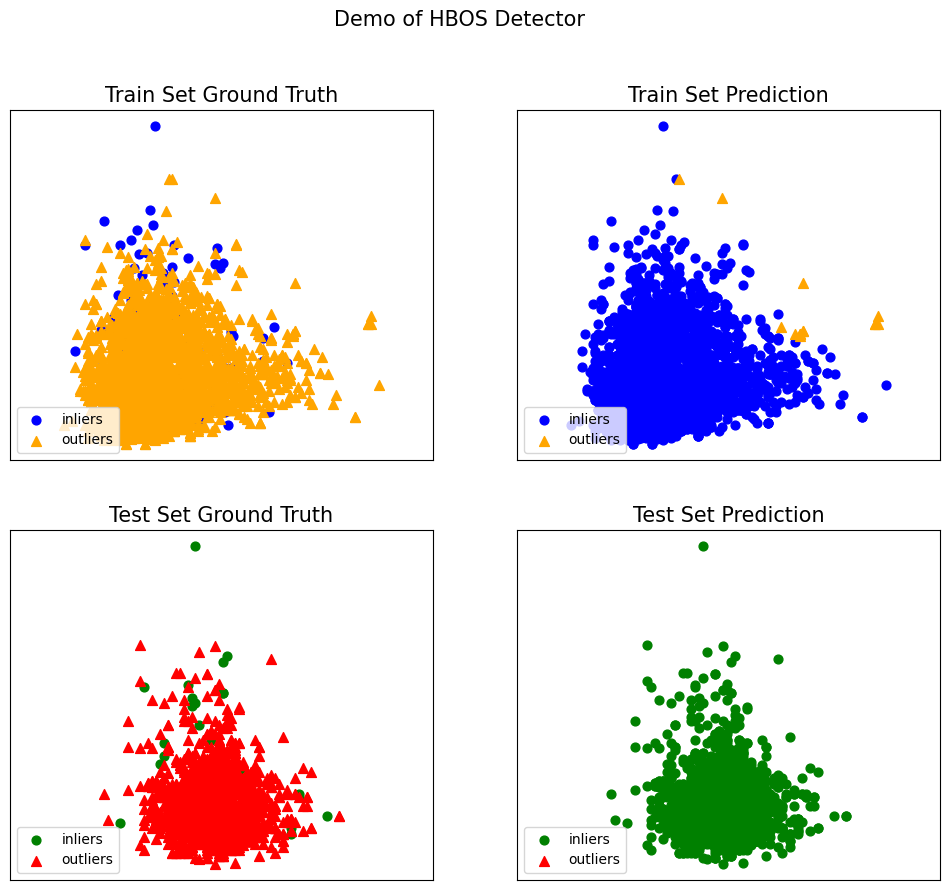

In [36]:
from pyod.models.hbos import HBOS

clf_hb=HBOS(n_bins=3, contamination=0.0367)
clf_hb.fit(train_data)

# get the prediction labels and outlier scores of the training data
train_pred_hb = clf_hb.labels_  # binary labels (0: inliers, 1: outliers)
train_scores_hb = clf_hb.decision_scores_  # raw outlier scores

# get the prediction on the test data
test_pred_hb = clf_hb.predict(test_data)  # outlier labels (0 or 1)
test_scores_hb = clf_hb.decision_function(test_data)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('HBOS', train_labels, train_scores_hb)
print("\nOn Test Data:")
evaluate_print('HBOS', test_labels, test_scores_hb)

visualize('HBOS', train_data, train_labels, test_data, test_labels, train_pred_hb, test_pred_hb, show_figure=True, save_figure=False)



<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 1

### Experiment with different values for the number of bins to see if you can increase the ROC score >= 0.75. 


</div>


On Training Data:
HBOS ROC:0.3953, precision @ rank n:0.9343

On Test Data:
HBOS ROC:0.3606, precision @ rank n:0.7949

On Training Data:
HBOS ROC:0.3943, precision @ rank n:0.9527

On Test Data:
HBOS ROC:0.4099, precision @ rank n:0.9737

On Training Data:
HBOS ROC:0.4036, precision @ rank n:0.9463

On Test Data:
HBOS ROC:0.3885, precision @ rank n:0.968

On Training Data:
HBOS ROC:0.3922, precision @ rank n:0.9445

On Test Data:
HBOS ROC:0.3612, precision @ rank n:0.9599

On Training Data:
HBOS ROC:0.3911, precision @ rank n:0.9469

On Test Data:
HBOS ROC:0.3723, precision @ rank n:0.9624

On Training Data:
HBOS ROC:0.4189, precision @ rank n:0.9584

On Test Data:
HBOS ROC:0.3843, precision @ rank n:0.9713

On Training Data:
HBOS ROC:0.4082, precision @ rank n:0.957

On Test Data:
HBOS ROC:0.3833, precision @ rank n:0.9727

On Training Data:
HBOS ROC:0.4055, precision @ rank n:0.9549

On Test Data:
HBOS ROC:0.3925, precision @ rank n:0.9729

On Training Data:
HBOS ROC:0.4127, precis


On Training Data:
HBOS ROC:0.4089, precision @ rank n:0.9563

On Test Data:
HBOS ROC:0.3544, precision @ rank n:0.9731

On Training Data:
HBOS ROC:0.4076, precision @ rank n:0.9563

On Test Data:
HBOS ROC:0.3786, precision @ rank n:0.9734

On Training Data:
HBOS ROC:0.4094, precision @ rank n:0.9574

On Test Data:
HBOS ROC:0.3982, precision @ rank n:0.973

On Training Data:
HBOS ROC:0.4164, precision @ rank n:0.9561

On Test Data:
HBOS ROC:0.4124, precision @ rank n:0.9736

On Training Data:
HBOS ROC:0.406, precision @ rank n:0.9565

On Test Data:
HBOS ROC:0.3456, precision @ rank n:0.9725

On Training Data:
HBOS ROC:0.3963, precision @ rank n:0.9564

On Test Data:
HBOS ROC:0.3515, precision @ rank n:0.9735

On Training Data:
HBOS ROC:0.403, precision @ rank n:0.9565

On Test Data:
HBOS ROC:0.3753, precision @ rank n:0.974

On Training Data:
HBOS ROC:0.4256, precision @ rank n:0.9565

On Test Data:
HBOS ROC:0.3924, precision @ rank n:0.9735

On Training Data:
HBOS ROC:0.3878, precisio

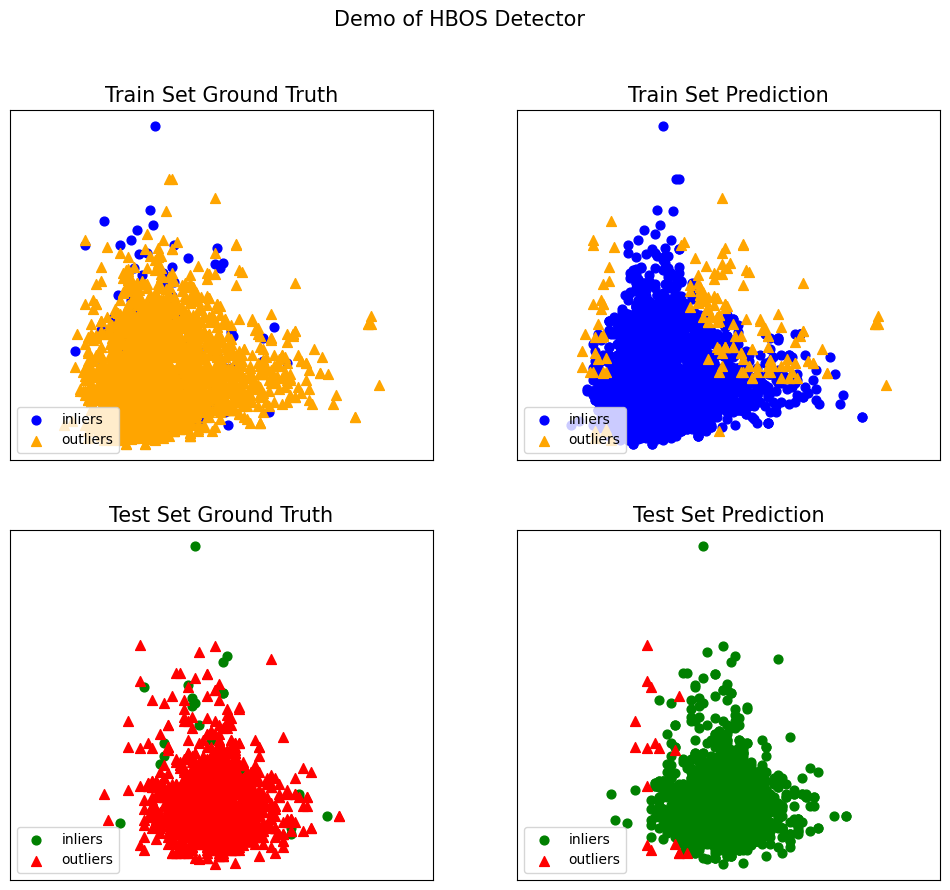

In [37]:
#visualize('HBOS', train_data, train_labels, test_data, test_labels, train_pred_hb, test_pred_hb, show_figure=True, save_figure=False)

for x in range(3, 100):
    clf_hb=HBOS(n_bins=x, contamination=0.0367)
    clf_hb.fit(train_data)

    # get the prediction labels and outlier scores of the training data
    train_pred_hb = clf_hb.labels_  # binary labels (0: inliers, 1: outliers)
    train_scores_hb = clf_hb.decision_scores_  # raw outlier scores
    
    # get the prediction on the test data
    test_pred_hb = clf_hb.predict(test_data)  # outlier labels (0 or 1)
    test_scores_hb = clf_hb.decision_function(test_data)  # outlier scores

    # evaluate and print the results
    print("\nOn Training Data:")
    a = evaluate_print('HBOS', train_labels, train_scores_hb)
    print("\nOn Test Data:")
    evaluate_print('HBOS', test_labels, test_scores_hb)
    
visualize('HBOS', train_data, train_labels, test_data, test_labels, train_pred_hb, test_pred_hb, show_figure=True, save_figure=False)


<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### Neighbourhood-based Methods

</div>

Neighbourhood based methods try to detect various types of multivariate outliers by considering neighbourhoods of datapoints.

## KNN

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 2

### Implement KNN with the pyod library. Use the Euclidean distance as the metric, and the average distance of the neighbours. Experiment with different values for n_neighbours. 

### Hint: https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn



</div>


On Training Data:
KNN < n_neighbours=5 > ROC:0.3673, precision @ rank n:0.9498

On Test Data:
KNN < n_neighbours=5 > ROC:0.3306, precision @ rank n:0.9656

On Training Data:
KNN < n_neighbours=10 > ROC:0.3675, precision @ rank n:0.9549

On Test Data:
KNN < n_neighbours=10 > ROC:0.3478, precision @ rank n:0.9731

On Training Data:
KNN < n_neighbours=15 > ROC:0.3677, precision @ rank n:0.956

On Test Data:
KNN < n_neighbours=15 > ROC:0.3524, precision @ rank n:0.9741

On Training Data:
KNN < n_neighbours=50 > ROC:0.3711, precision @ rank n:0.9558

On Test Data:
KNN < n_neighbours=50 > ROC:0.3675, precision @ rank n:0.9736

On Training Data:
KNN < n_neighbours=100 > ROC:0.374, precision @ rank n:0.9561

On Test Data:
KNN < n_neighbours=100 > ROC:0.3671, precision @ rank n:0.9731

On Training Data:
KNN < n_neighbours=200 > ROC:0.3778, precision @ rank n:0.9561

On Test Data:
KNN < n_neighbours=200 > ROC:0.3605, precision @ rank n:0.9731

On Training Data:
KNN < n_neighbours=300 > ROC:0.37

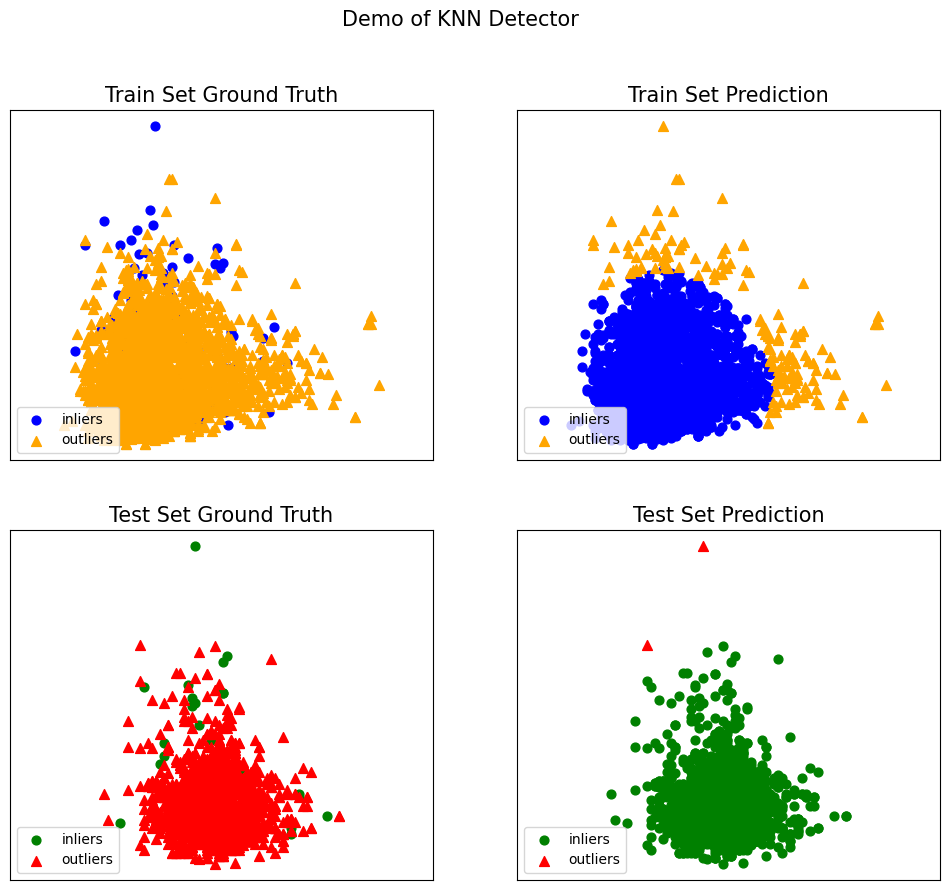

In [38]:
#Please implement Task 2 here
from pyod.models.knn import KNN

n_neighbours_list = [5, 10, 15, 50, 100, 200, 300, 1000, 2500, 4546]

for n_neighbours in n_neighbours_list:
    knn_model = KNN(n_neighbors=n_neighbours, metric='euclidean', method='mean', contamination = 0.0367)
    
    knn_model.fit(train_data)

    train_pred_knn = knn_model.labels_
    train_scores_knn = knn_model.decision_scores_ 
    
    test_pred_knn = knn_model.predict(test_data)
    test_scores_knn = knn_model.decision_function(test_data) 
    
    print("\nOn Training Data:")
    evaluate_print(f"KNN < n_neighbours={n_neighbours} >", train_labels, train_scores_knn)
    
    print("\nOn Test Data:")
    evaluate_print(F"KNN < n_neighbours={n_neighbours} >", test_labels, test_scores_knn)
    

visualize('KNN', train_data, train_labels, test_data, test_labels, train_pred_knn, test_pred_knn, show_figure=True, save_figure=False)

## LOF or COF

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 3

### Take a look at the scatterplot of the dataset with our two feature fixed acidity and volatile acidity. Determine whether we should use LOF or COF on the dataset and implement it. Give a reason for your choice?


### Hint: Use functions from the PyOD library



</div>

<img src="images/scatter.png" alt="Alternative text" />


On Training Data:
LOFs ROC:0.4006, precision @ rank n:0.9574

On Test Data:
LOFs ROC:0.446, precision @ rank n:0.9731


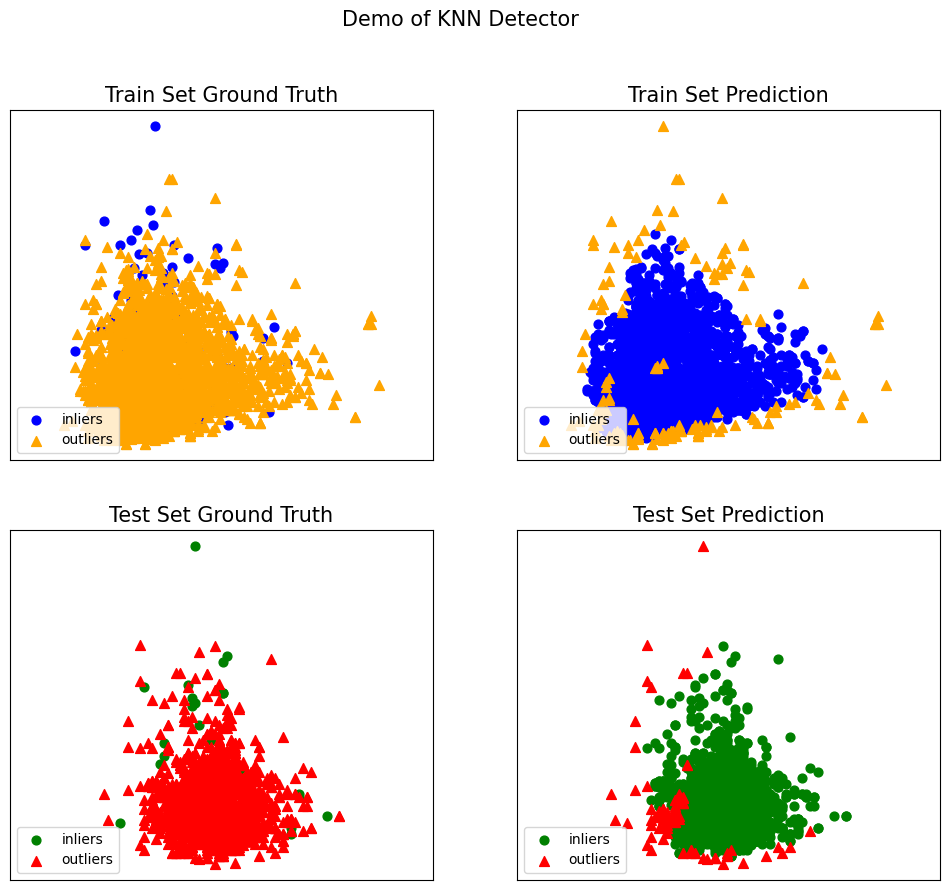

In [39]:
#Please implement Task 3 here

#LOF, since there are a lot of outliers which are in clusters with inliers, hence LOF is better.
#If many outliers where isolated from inliers, COF would be the way to go

from pyod.models.lof import LOF

lof_model = LOF(contamination = 0.0367)
lof_model.fit(train_data)

train_pred_lof = lof_model.labels_
train_scores = lof_model.decision_scores_

test_pred_lof = lof_model.predict(test_data)
test_scores = lof_model.decision_function(test_data) 

print("\nOn Training Data:")
evaluate_print('LOFs', train_labels, train_scores)
print("\nOn Test Data:")
evaluate_print('LOFs', test_labels, test_scores)

visualize('KNN', train_data, train_labels, test_data, test_labels, train_pred_lof, test_pred_lof, show_figure=True, save_figure=False)

<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### One-class classification based Methods

</div>

One-class classification based methods detect anomalies by finding a region of space where the majority of data samples reside with the highest density.

## One-class SVM

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 4

### Implement OCSVM with a linear or non-linear kernel of your choice.

   
### Hint: Use functions from the PyOD library https://pyod.readthedocs.io/en/latest/_modules/pyod/models/ocsvm.html



</div>


On Training Data:
OCSVM-nonlinear ROC:0.4094, precision @ rank n:0.957

On Test Data:
OCSVM-nonlinear ROC:0.3984, precision @ rank n:0.9731


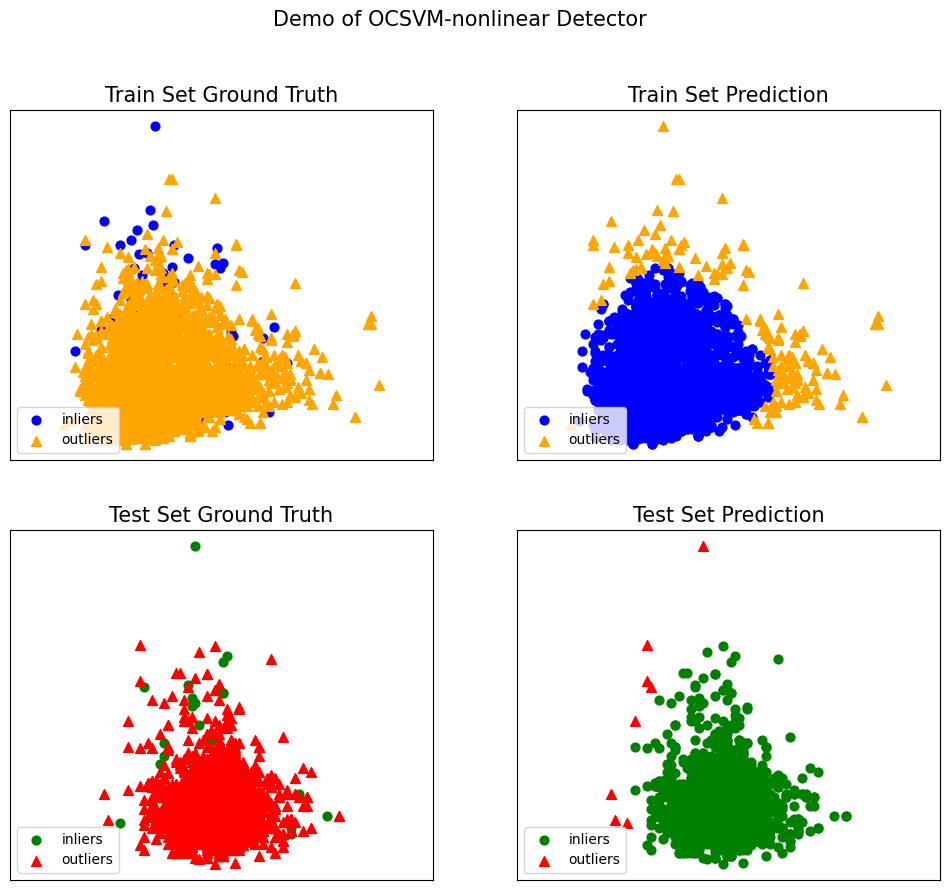


On Training Data:
OCSVM-linear ROC:0.3902, precision @ rank n:0.957

On Test Data:
OCSVM-linear ROC:0.3603, precision @ rank n:0.9752


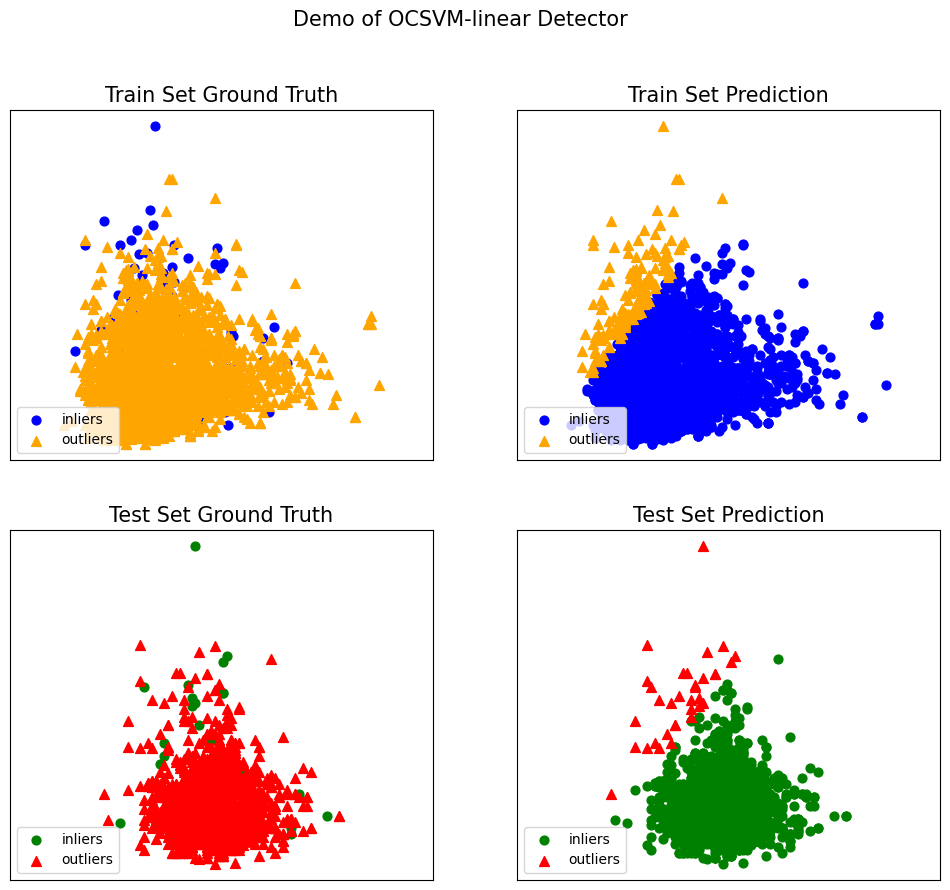

In [40]:
#Please implement Task 4 here
from pyod.models.ocsvm import OCSVM

kernel_type = 'rbf'
ocsvm_model = OCSVM(kernel=kernel_type, contamination=0.0367)

ocsvm_model.fit(train_data)

train_scores = ocsvm_model.decision_scores_
train_pred_ocsvm = ocsvm_model.labels_

test_scores = ocsvm_model.decision_function(test_data)
test_pred_ocsvm = ocsvm_model.predict(test_data)

print("\nOn Training Data:")
evaluate_print('OCSVM-nonlinear', train_labels, train_scores)
print("\nOn Test Data:")
evaluate_print('OCSVM-nonlinear', test_labels, test_scores)

visualize('OCSVM-nonlinear', train_data, train_labels, test_data, test_labels, train_pred_ocsvm, test_pred_ocsvm, show_figure=True, save_figure=False)

kernel_type = 'linear'
ocsvm_model = OCSVM(kernel=kernel_type, contamination=0.0367)

ocsvm_model.fit(train_data)

train_scores = ocsvm_model.decision_scores_
train_pred_ocsvm = ocsvm_model.labels_

test_scores = ocsvm_model.decision_function(test_data)
test_pred_ocsvm = ocsvm_model.predict(test_data)

print("\nOn Training Data:")
evaluate_print('OCSVM-linear', train_labels, train_scores)
print("\nOn Test Data:")
evaluate_print('OCSVM-linear', test_labels, test_scores)

visualize('OCSVM-linear', train_data, train_labels, test_data, test_labels, train_pred_ocsvm, test_pred_ocsvm, show_figure=True, save_figure=False)

<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### Clustering-based Methods

</div>

Clustering-based approaches assume that normal data belongs to large and dense clusters while, anomalies either do not belong to any of the clusters or form very small clusters.

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 5

### Implement DBSCAN on the dataset. Experiment with 2 different values for epsilon and minpts. Report your results below. Which hyperparameter values give you better results??


Please note that we will use the sklearn version (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

</div>

In [41]:
#Please implement Task 5 here

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_values = [0.1, 0.2, 0.4, 0.6]
min_samples_values = [5, 10, 15, 20, 25, 30]

for eps in eps_values:
    for min_samples in min_samples_values:

        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

        dbscan_labels = dbscan_model.fit_predict(data)

        silhouette = silhouette_score(data, dbscan_labels)

        # Print or store the results for evaluation
        print(f"DBSCAN <eps={eps}, min_samples={min_samples}> - Silhouette Score: {silhouette}")
# As we can see from the results of the for loop, a higher epsilon create a better silhouette score, 
# although increasing the amount of samples decreases it.
# It is a score between -1 to 1. The higher the better.

DBSCAN <eps=0.1, min_samples=5> - Silhouette Score: 0.2501348713055352
DBSCAN <eps=0.1, min_samples=10> - Silhouette Score: 0.21964245325037562
DBSCAN <eps=0.1, min_samples=15> - Silhouette Score: 0.20547042597364745
DBSCAN <eps=0.1, min_samples=20> - Silhouette Score: 0.18676684768102567
DBSCAN <eps=0.1, min_samples=25> - Silhouette Score: 0.14887830739197502
DBSCAN <eps=0.1, min_samples=30> - Silhouette Score: 0.14236728622887096
DBSCAN <eps=0.2, min_samples=5> - Silhouette Score: 0.6908099701591086
DBSCAN <eps=0.2, min_samples=10> - Silhouette Score: 0.693970613723539
DBSCAN <eps=0.2, min_samples=15> - Silhouette Score: 0.6608988687724183
DBSCAN <eps=0.2, min_samples=20> - Silhouette Score: 0.6519656222352459
DBSCAN <eps=0.2, min_samples=25> - Silhouette Score: 0.6527159307845604
DBSCAN <eps=0.2, min_samples=30> - Silhouette Score: 0.6916273157207825
DBSCAN <eps=0.4, min_samples=5> - Silhouette Score: 0.7931948495701658
DBSCAN <eps=0.4, min_samples=10> - Silhouette Score: 0.78581347

<div class='alert alert-block alert-success' style="font-weight:bolder">
    
### Task 6

### Compare the results from HBOS, One-class SVM, LOF or COF and KNN. Which one performed better? Can you think of any reasons why?.
    
</div>

### Write your answer to task 6 here.

In [42]:
# I would say that the "OCSVM-nonlinear"  model performed the best, 
# since according to the plots that is the one where the predicted outliers really look like outliers,
# as well as marking many outliers in both the test as well as trained data, and not just 3 or 5 like the HBOS,
# or performing good on the trained set but not the test set.